In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
training = pd.read_csv("/content/drive/My Drive/training.csv")

In [0]:
training.head()

,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [0]:
!mkdir Images

In [0]:
cd Images

/content/Images


In [0]:
!unzip "/content/drive/My Drive/Copy of FlipkartGridStage2DataSetImages.zip"

In [0]:
cd /content

/content


In [0]:
import keras.backend as K

Using TensorFlow backend.


In [0]:
def iou(box1, box2):

    xi1 = K.maximum(box1[:, 0], box2[:, 0])
    xi2 = K.minimum(box1[:, 1], box2[:, 1])
    yi1 = K.maximum(box1[:, 2], box2[:, 2])
    yi2 = K.minimum(box1[:, 3], box2[:, 3])

    inter_area = K.maximum(xi2-xi1, 0) * K.maximum(yi2-yi1, 0)

    # Union(A,B) = Area(A) + Area(B) - Intersection(A,B)
    box1_area = (box1[:, 3] - box1[:, 2]) * (box1[:, 1] - box1[:, 0])
    box2_area = (box2[:, 3] - box2[:, 2]) * (box2[:, 1] - box2[:, 0])
    union_area = (box1_area + box2_area - inter_area)
    iou = inter_area / union_area

    return K.mean(iou)

In [0]:
def add_name(row):
  row["image_name"] = "/content/Images/images/" + row["image_name"]
  row["x1"] = row["x1"]/4
  row["x2"] = row["x2"]/4
  row["y1"] = row["y1"]/4
  row["y2"] = row["y2"]/4
  return row

In [0]:
training2 = training.apply(add_name, axis=1)

In [0]:
training2.head()

,image_name,x1,x2,y1,y2
0,/content/Images/images/JPEG_20160706_121146_10...,28.75,123.75,35.75,81.25
1,/content/Images/images/JPEG_20161119_174038_10...,5.75,114.25,15.25,102.25
2,/content/Images/images/14744492765111147030933...,9.25,150.25,3.25,117.50
3,/content/Images/images/147772332675720161028_1...,6.75,150.50,40.50,96.25
4,/content/Images/images/1473315333651DeeplearnS...,15.00,146.50,43.50,81.25


In [0]:
from keras.layers import Input

In [0]:
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.models import Model

In [0]:
ind = int(len(training2) * 0.25)

val_data = training2[:ind]
train_data = training2[ind:]

In [0]:
len(val_data), len(train_data)

(3500, 10500)

In [0]:
val_data.head()

,image_name,x1,x2,y1,y2
0,/content/Images/images/JPEG_20160706_121146_10...,28.75,123.75,35.75,81.25
1,/content/Images/images/JPEG_20161119_174038_10...,5.75,114.25,15.25,102.25
2,/content/Images/images/14744492765111147030933...,9.25,150.25,3.25,117.50
3,/content/Images/images/147772332675720161028_1...,6.75,150.50,40.50,96.25
4,/content/Images/images/1473315333651DeeplearnS...,15.00,146.50,43.50,81.25


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
trainaug = ImageDataGenerator(rescale=1/255.0)
valaug  = ImageDataGenerator(rescale=1/255.0)

In [0]:
traingen = trainaug.flow_from_dataframe(dataframe=train_data, 
                                         x_col="image_name", 
                                         y_col=["x1","x2", "y1", "y2"],
                                         directory=None,target_size=(120,160),
                                          class_mode="other", batch_size=64)
valgen =  valaug.flow_from_dataframe(dataframe=val_data, 
                                         x_col="image_name", 
                                         y_col=["x1","x2", "y1", "y2"],
                                         directory=None,target_size=(120,160),
                                          class_mode="other", batch_size=64)

Found 10500 validated image filenames.
Found 3500 validated image filenames.


In [0]:
import keras

In [0]:
from keras.applications.densenet import DenseNet169

In [0]:
basemodel = DenseNet169(include_top=False, weights="imagenet", input_tensor=Input(shape=(120,160,3)), pooling='avg')

51879936/51877672 [==============================] - 1s 0us/step


In [0]:
basemodel.summary()

In [0]:
headmodel = basemodel.output
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(32, activation="relu")(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(4, activation="relu")(headmodel)
model = Model(inputs=basemodel.input, outputs=headmodel)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 126, 166, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 60, 80, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 60, 80, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
for layer in model.layers:
  layer.trainable = False

In [0]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss="mse", metrics=[iou])

In [0]:
hist = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 20,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_dn.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 1/20
164/164 [==============================] - 167s 1s/step - loss: 683.2572 - iou: 0.4241 - val_loss: 15878.4780 - val_iou: 0.0597
Epoch 2/20
164/164 [==============================] - 154s 942ms/step - loss: 689.8432 - iou: 0.4202 - val_loss: 175326.7663 - val_iou: 0.1157
Epoch 3/20
164/164 [==============================] - 159s 967ms/step - loss: 671.3154 - iou: 0.4249 - val_loss: 287.6397 - val_iou: 0.5499
Epoch 4/20
164/164 [==============================] - 158s 966ms/step - loss: 653.8979 - iou: 0.4282 - val_loss: 4670.5011 - val_iou: 0.5496
Epoch 5/20
164/164 [==============================] - 159s 970ms/step - loss: 658.7897 - iou: 0.4281 - val_loss: 330.6998 - val_iou: 0.5166
Epoch 6/20
164/164 [==============================] - 158s 963ms/step - loss: 634.3530 - iou: 0.4337 - val_loss: 359.5755 - val_iou: 0.5436
Epoch 7/20
164/164 [==============================] - 159s 967ms/step - loss: 617.7786 - iou: 0.4356 - val_loss: 274.6950 - val_iou: 0.5573
Epoch 8/20
164/16

In [0]:
hist2 = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 60,
                            initial_epoch=20,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_dn.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 21/60
164/164 [==============================] - 165s 1s/step - loss: 443.2155 - iou: 0.4901 - val_loss: 183.6896 - val_iou: 0.5936
Epoch 22/60
164/164 [==============================] - 158s 964ms/step - loss: 443.3950 - iou: 0.4901 - val_loss: 262.0638 - val_iou: 0.5324
Epoch 23/60
164/164 [==============================] - 159s 967ms/step - loss: 450.9062 - iou: 0.4889 - val_loss: 148.1034 - val_iou: 0.6486
Epoch 24/60
164/164 [==============================] - 158s 965ms/step - loss: 439.0230 - iou: 0.4927 - val_loss: 240.3840 - val_iou: 0.5884
Epoch 25/60
164/164 [==============================] - 161s 983ms/step - loss: 416.4124 - iou: 0.5017 - val_loss: 205.9420 - val_iou: 0.6067
Epoch 26/60
164/164 [==============================] - 160s 974ms/step - loss: 407.4687 - iou: 0.5050 - val_loss: 165.0028 - val_iou: 0.6194
Epoch 27/60
164/164 [==============================] - 159s 972ms/step - loss: 404.3837 - iou: 0.5055 - val_loss: 134.9454 - val_iou: 0.6582
Epoch 28/60
164/

In [0]:
hist3 = model.fit_generator(generator=traingen,
                          steps_per_epoch = traingen.n//traingen.batch_size,
                            validation_data = valgen,
                          validation_steps = valgen.n//valgen.batch_size,
                          epochs = 100,
                            initial_epoch=60,
                          callbacks=[keras.callbacks.ModelCheckpoint(
                          'Model_dn.val-iou={val_iou:.2f}.val-mse={val_loss:.2f}.h5',
                          monitor='val_iou',
                          verbose=0,
                          save_best_only=True,
                          save_weights_only=False,
                           mode='max',
                              period=1
                             )])

Epoch 61/100
164/164 [==============================] - 157s 957ms/step - loss: 190.6807 - iou: 0.6209 - val_loss: 84.3770 - val_iou: 0.7200
Epoch 62/100
164/164 [==============================] - 149s 907ms/step - loss: 180.5170 - iou: 0.6285 - val_loss: 214.0765 - val_iou: 0.6353
Epoch 63/100
164/164 [==============================] - 150s 914ms/step - loss: 185.3904 - iou: 0.6254 - val_loss: 249.1941 - val_iou: 0.6314
Epoch 64/100
164/164 [==============================] - 149s 908ms/step - loss: 177.2723 - iou: 0.6323 - val_loss: 89.7611 - val_iou: 0.7105
Epoch 65/100
164/164 [==============================] - 148s 901ms/step - loss: 172.9171 - iou: 0.6343 - val_loss: 84.7947 - val_iou: 0.7198
Epoch 66/100
164/164 [==============================] - 148s 901ms/step - loss: 166.4259 - iou: 0.6411 - val_loss: 207.5241 - val_iou: 0.6420
Epoch 67/100
164/164 [==============================] - 148s 900ms/step - loss: 158.9316 - iou: 0.6468 - val_loss: 79.3133 - val_iou: 0.7438
Epoch 68/1

In [0]:
t_loss = hist.history["loss"] + hist2.history["loss"] + hist3.history["loss"]
v_loss = hist.history["val_loss"] + hist2.history["val_loss"] + hist3.history["val_loss"]

In [0]:
t_iou = hist.history["iou"] + hist2.history["iou"] + hist3.history["iou"]
v_iou = hist.history["val_iou"] + hist2.history["val_iou"] + hist3.history["val_iou"]

In [0]:
import matplotlib.pyplot as plt

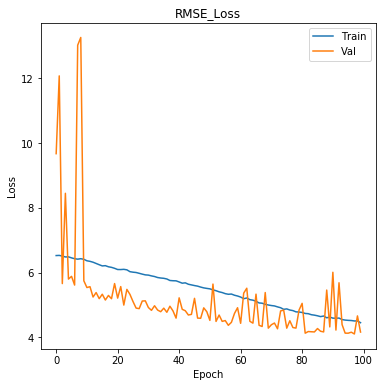

In [0]:
plt.figure(figsize=(6,6))
plt.plot(np.log(t_loss))
plt.plot(np.log(v_loss))
plt.title('RMSE_Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

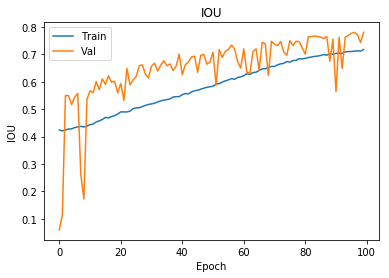

In [0]:
plt.plot(t_iou)
plt.plot(v_iou)
plt.title('IOU')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

Highest Validation IOU - 0.79